In [1]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.datasets import cifar10
import torch

/usr0/home/cjyeh/anaconda/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num_classes = 10 #    
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# CIFAR-10 class names 
class_names = dict()
class_names[0] = 'airplane' 
class_names[1] = 'automobile'
class_names[2] = 'bird'
class_names[3] = 'cat' 
class_names[4] = 'deer'
class_names[5] = 'dog' 
class_names[6] = 'frog' 
class_names[7] = 'horse'
class_names[8] = 'ship' 
class_names[9] = 'truck'

## load all the data you need here.

with open("../output/weight_matrix_Cifar.pkl", "rb") as input_file:
    [weight_matrix,y_predict] = pickle.load(input_file)
    
output_test = pickle.load(open('../data/output_test_cifar.pkl', 'rb'))
output_test_labels = np.argmax(output_test, axis=1)
output_train_labels = np.argmax(y_predict, axis=1)

with open('../data/intermediate34_train.pkl' , 'rb') as f:
    train_output34 = pickle.load(f)
    
with open('../data/intermediate34_test.pkl', 'rb') as f:
    test_output34 = pickle.load(f)
    
with open('../data/intermediate36_train.pkl' , 'rb') as f:
    train_output36 = pickle.load(f)
    
with open('../data/intermediate36_test.pkl', 'rb') as f:
    test_output36 = pickle.load(f)
    
with open('../data/presoft_test.pkl', 'rb') as f:
    presoft_test = pickle.load(f)
    
# Load the influence function values here
f = np.load('../output/cifar_inf_test_1000.npz')
inf = f['influences']

In [3]:
### Compute representer values
tensor_train34 = torch.FloatTensor(train_output34)
tensor_test34 = torch.FloatTensor(test_output34)
w_tensor = torch.FloatTensor(weight_matrix)

prod = torch.matmul(tensor_train34,torch.t(tensor_test34))
dd = y_test.flatten()
one_hot = np.eye(10)[dd]
one_hot_tensor = torch.FloatTensor(one_hot)
prod2 = torch.matmul(w_tensor, torch.t(one_hot_tensor))

inf_ours = torch.mul(prod, prod2)
inf_ours = inf_ours.cpu().numpy() # matrix of representer values

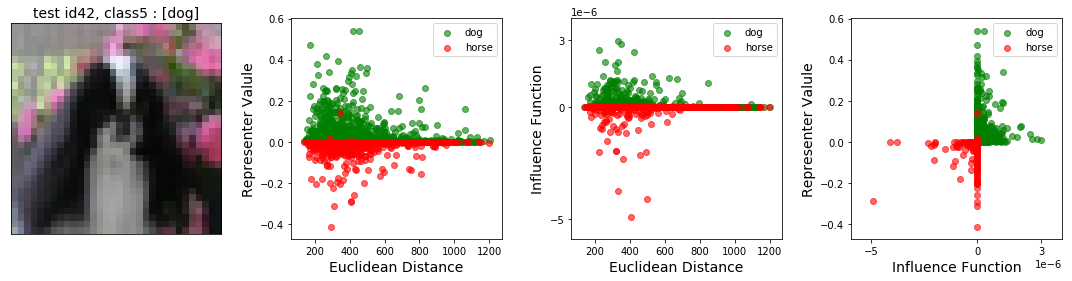

In [4]:
## Specify a test index to inspect
test_idx = 42

class1 = y_test.flatten()[test_idx] # positive class (the class of the test point)
class_list = list(range(num_classes)) 
class2 = 7 # horse

train_idx_in_class1 = np.where(y_train == class1)[0]
train_idx_in_class2 = np.where(y_train == class2)[0]
pos = inf_ours[train_idx_in_class1, test_idx]
neg = inf_ours[train_idx_in_class2, test_idx]

## Compute euclidean distances
euc_pos = np.sum((x_train[train_idx_in_class1,:] / 255. - x_test[test_idx] / 255.) ** 2, axis=(1,2,3))
euc_neg = np.sum((x_train[train_idx_in_class2,:] / 255. - x_test[test_idx] / 255.) ** 2, axis=(1,2,3)) 

## Compute influence values
inf_pos = inf[train_idx_in_class1, test_idx]
inf_neg = inf[train_idx_in_class2, test_idx]

f, ax = plt.subplots(1, 4, figsize=(15,4))

# Test image of interest
ax[0].imshow(x_test[test_idx])
ax[0].set_title('test id%d, class%d : [%s]'%(test_idx, class1, class_names[class1]), fontsize=14)
ax[0].set_xticks(())
ax[0].set_yticks(())

# ours vs euclidean distance
pp = ax[1].scatter(euc_pos, pos, c='g', alpha=0.6)
nn = ax[1].scatter(euc_neg, neg, c='r', alpha=0.6)
ax[1].set_xlabel('Euclidean Distance', fontsize=14)
ax[1].set_ylabel('Representer Valule', fontsize=14)
ax[1].legend([pp, nn], ['%s'%class_names[class1], '%s'%class_names[class2]], loc='best')
#ax[1].set_title('Representer Value vs Euclidean Distance')

# influence vs euclidean
pp = ax[2].scatter(euc_pos, inf_pos, c='g', alpha=0.6)
nn = ax[2].scatter(euc_neg, inf_neg, c='r', alpha=0.6)
ax[2].set_xlabel('Euclidean Distance', fontsize=14)
ax[2].set_ylabel('Influence Function', fontsize=14)
ax[2].legend([pp, nn], ['%s'%class_names[class1], '%s'%class_names[class2]], loc='best')
#ax[2].set_title('Influence Function vs Euclidena Distance')
ax[2].set_yticks((-5e-6, 0, 3e-6))
ax[2].set_ylim(min(np.min(inf_pos), np.min(inf_neg)) - 1e-6, max(np.max(inf_pos), np.max(inf_neg)) + 1e-6)
ax[2].ticklabel_format(style='sci', scilimits=(0,0), axis='y')

# ours vs influence
pp = ax[3].scatter(inf_pos, pos, c='g', alpha=0.6)
nn = ax[3].scatter(inf_neg, neg, c='r', alpha=0.6)
ax[3].set_xlabel('Influence Function', fontsize=14)
ax[3].set_ylabel('Representer Valule', fontsize=14)
ax[3].legend([pp, nn], ['%s'%class_names[class1], '%s'%class_names[class2]], loc='best')
#ax[3].set_title('Representer Value vs Influence Function')
ax[3].set_xticks((-5e-6, 0, 3e-6))
ax[3].set_xlim(min(np.min(inf_pos), np.min(inf_neg))- 1e-6, max(np.max(inf_pos), np.max(inf_neg)) + 1e-6)
ax[3].ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.tight_layout()
plt.savefig('euclideaninfcompare.png', dpi=200)


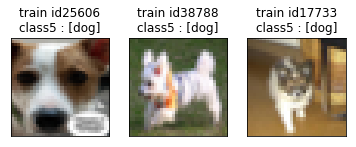

In [5]:
# Representer value is big, but influence value is small

zero_infs = np.where(inf[:, test_idx] == 0)[0]
tt = list(set(train_idx_in_class1) & set(zero_infs))
bb = list(set(train_idx_in_class2) & set(zero_infs))
tmp_id = np.argsort(inf_ours[tt, test_idx])
tmp_idd = np.argsort(inf_ours[bb, test_idx])

f, axs = plt.subplots(1, 3, figsize=(6,5))
for i in range(1,4):
    true_id = tt[tmp_id[-i]]
    axs[i-1].imshow(x_train[true_id])
    axs[i-1].set_xticks(())
    axs[i-1].set_yticks(())
    axs[i-1].set_title('train id%d\nclass%d : [%s]'%(true_id, class1, class_names[class1]))
plt.savefig('zeroinf_but_bigreps.png', dpi=200)

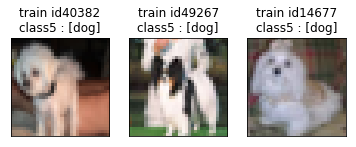

In [6]:
# Representer value is almost zero, but influence value is big

zero_reps = np.where(np.abs(inf_ours[:, test_idx]) < 1e-11)[0]
tt = list(set(train_idx_in_class1) & set(zero_reps))
bb = list(set(train_idx_in_class2) & set(zero_reps))
tmp_id = np.argsort(inf[tt, test_idx])
tmp_idd = np.argsort(inf[bb, test_idx])

f, axs = plt.subplots(1, 3, figsize=(6,5))
for i in range(1,4):
    true_id = tt[tmp_id[-i]]
    axs[i-1].imshow(x_train[true_id])
    axs[i-1].set_xticks(())
    axs[i-1].set_yticks(())
    axs[i-1].set_title('train id%d\nclass%d : [%s]'%(true_id, class1, class_names[class1]))
plt.savefig('zeroreps_but_biginf.png', dpi=200)
